## ECE495 Intro to programming neurons with Nengo: Representation

In this demonstration we will:

1. Represent a constant input value with a single neuron using Nengo
2. Understand output plots from Nengo (raster plots, decoded neural responses, tuning curves, and more)
3. Tune parameters to understand how to better represent different inputs values using one neuron
4. Repeat 1-3 with 10 neurons
5. Repeat for various time-varying input signals.

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import nengo
from nengo.dists import Uniform
from nengo.processes import WhiteSignal
from nengo.utils.ensemble import tuning_curves
from nengo.utils.ipython import hide_input
from nengo.utils.matplotlib import rasterplot
from scipy.stats import norm

### Represent (i.e. Encode) Input Data using One Neuron

To do anything with data in Nengo, we must first convert the input data into spiking data using Nengo neuron ensembles. This is biologically inspired: neural populations represent time-varying signals through their spiking responses (recall the human visual system).

We start with a Nengo node that provides the input to a neuron in our Nengo model - this is essentially just a way to pass data from regular Python into a Nengo model filled with neurons. The Nengo neuron then converts the data to spikes (i.e. the neuron encodes the input data). We can then check to see how well our Nengo neuron can represent our input data by decoding the spikes.

Key terms:
- Encode: convert data to spikes
- Decode: convert spikes to numeric values (hopefully looks like our input)

To understand how Nengo neurons encode inputs, we will first look at a single neuron encoding a constant value.

#### Create your input

Start with a positive value between -1 and 1.

In [8]:
nengo_inp = .25

#### Create your model

Every Nengo network requires a model. The model holds all of your nodes, neurons, connections, probes, and other functionality. 

In [9]:
model = nengo.Network(label="Representation")

#### Add to your model

You can adjust or add onto your model anytime using the same `with model:` command. 

In [23]:

# Create a model to perform the sorting
with model:

    # Add input node 
    input_node = nengo.Node(nengo_inp)


    # Add a single neuron to encode the input
    input_neuron = nengo.Ensemble(n_neurons=1, dimensions=1,
        # Set your intercept (where the neuron starts spiking)
        # uniform = values uniformly distributed 
        # between the first and second input, one for each neuron. 
        # If you want a specific value, set both inputs to same value. -->this is the threshold.
        intercepts=Uniform(-.5,-.5),
        # Set the maximum firing rate of the neuron (Hz)
        max_rates=Uniform(100,100),
        # Set the neuron's firing rate to increase for values 
        # higher than (1) or lower than  (-1) your intercept
        # Values farther from the intercept elicit higher spike rates
        encoders=[[-1]]) #--> bc this is 1 its saying if im greater than 0 then I want to spike. if it was -1 it would spike more if it was closer to -1

    # Connect the node to the encoding neuron
    inp_conn = nengo.Connection(input_node, input_neuron)

    ## Add probes to see outputs throughout the model
    # This probe captures the non-spiking input value
    input_probe_node = nengo.Probe(input_node)

    # This probe displays the decoded neural representation of the input
    input_probe_neuron = nengo.Probe(input_neuron, synapse=0.1)

    # This probe captures the actual spikes from the neuron
    spikes = nengo.Probe(input_neuron.neurons)

    # These probes captures the neuron potential    
    membranePotential = nengo.Probe(input_neuron.neurons, "voltage")

#### Run your model

Once you've built it, it's time to see what it can do.

In [24]:
# Build the simulator to run the model containing just input encoding
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(1)

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


#### Analyze your model outputs

Plot the outputs collected from Nengo probes. 

(0.0, 1.0)

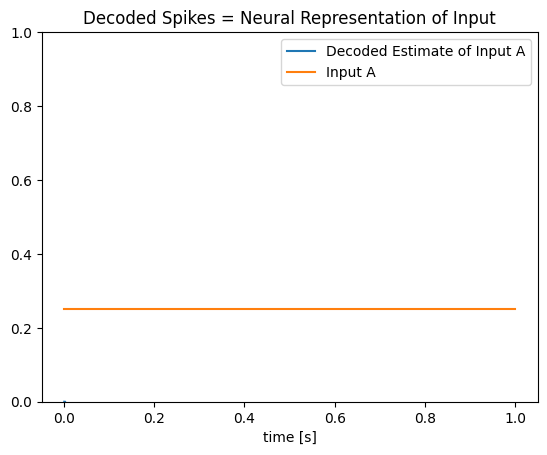

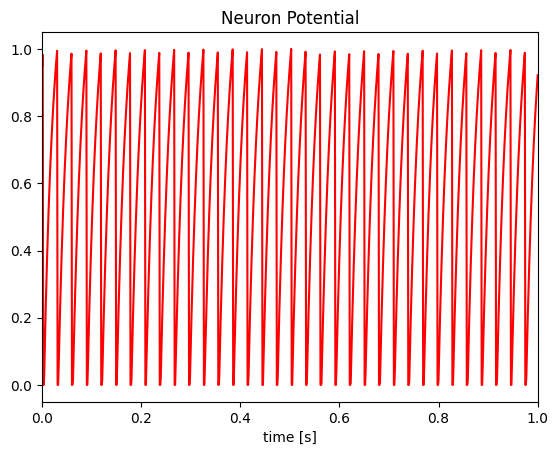

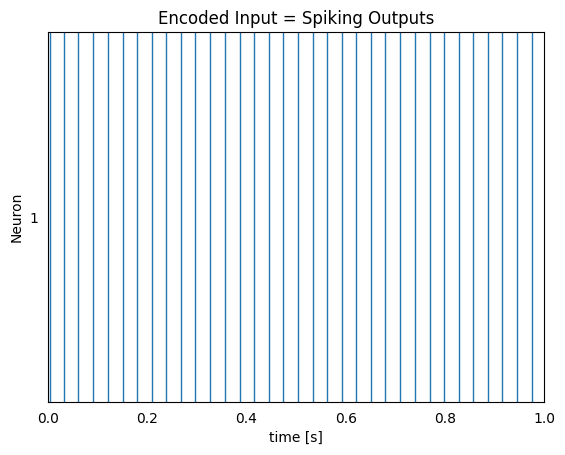

In [26]:
# Plot the input signals and decoded ensemble values
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe_neuron], label="Decoded Estimate of Input A")
plt.plot(sim.trange(), sim.data[input_probe_node], label="Input A")
plt.legend()
plt.ylim(0, 1)
plt.xlabel("time [s]")
plt.title("Decoded Spikes = Neural Representation of Input")

# Plot the soma voltages of the neurons
plt.figure()
plt.plot(sim.trange(), sim.data[membranePotential][:, 0], "r")
plt.xlim(0, 1)
plt.xlabel("time [s]")
plt.title("Neuron Potential")

# Plot the spiking output of the ensemble
plt.figure()
rasterplot(sim.trange(), sim.data[spikes])
plt.ylabel("Neuron")
plt.xlabel("time [s]")
plt.title("Encoded Input = Spiking Outputs")
plt.xlim(0, 1)

We can see that this single neuron cannot perfectly represent our input value. We could fine tune parameters to a specific value to get it to perfectly represent it; however, that's not generalizable. BUT! **We will still do that to see how the parameters really affect representations (soon).**

We would expect constant spikes evenly spaced as we are sending in a constant value. We would expect more spikes for larger values, fewer for smaller values.

We can see that the membrane potential increases and reaches a certain value, a spike is emmitted, and the membrane potential resets.



#### Further Analysis

Input signals drive neural populations based on each neuron’s "tuning curve".

The tuning curve describes how much a particular neuron will fire as a function of the input signal. In this case, our input signal is a constant value over 1 second. We can plot the tuning curve to better understand our outputs.

Build finished in 0:00:01.                                                      


Text(0, 0.5, 'Firing rate (Hz)')

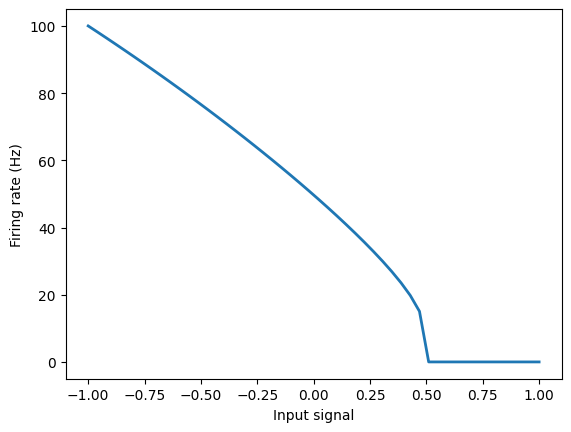

In [30]:
def aligned(n_neurons, radius=0.9):
    intercepts = np.linspace(-radius, radius, n_neurons)
    encoders = np.tile([[1], [-1]], (n_neurons // 2, 1))
    intercepts *= encoders[:, 0]
    return intercepts, encoders

with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(input_neuron, sim)

plt.figure()
plt.plot(eval_points, activities, lw=2)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)")

This plot tells us that for a value just barely above zero, it will have a firing rate of about 20Hz. If we had a value nearing 1, the firing rate would be close to our max firing rate we set for the neuron, 100Hz. Anything less than zero will not fire at all.

### Okay, but how did we go from spikes to the neural representation of the value?

For a single neuron, we must first recall what a membrane action potential looks like. For each binary spike, the biological equivalent is the membrane action potential at that time step. This means you can multiply each spike by the neuron action potential shape - dependent on tau (remember that?!) and add them up. At this point, your neuron representation should be approximately the same shape as your input (for a constant value, just a straight line). If you are using one neuron in your ensemble, this should be very similar to your input signal!

We will approximate the neuron potential as a Gaussian curve (because those are easier to plot). Then we will multiply each spike by the Guassian curve and add all of those voltages together to plot our encoded input values. 

Recall Key Terms: 
1. We encode our input using spikes
2. _We then decode those spikes to determine how well the neuron approximates our input_

Here's our Gaussian curve to approximate a neuron action potential:

Text(0.5, 1.0, 'Approximated Membrane Action Potential')

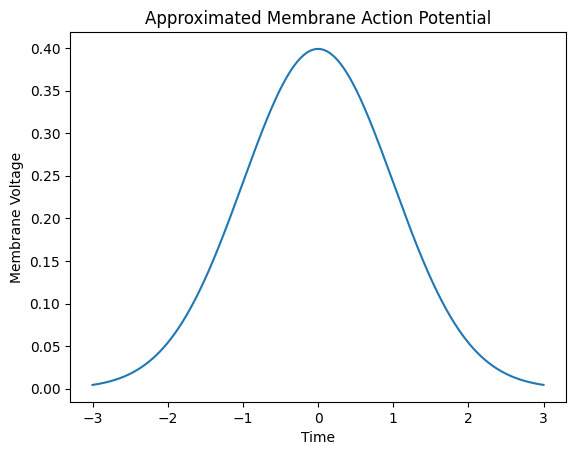

In [31]:
# x-axis ranges from -3 and 3 with .001 steps
x = np.arange(-3, 3, .001)

# plot normal distribution with mean 0 and standard deviation 1
plt.figure()
plt.plot(x, norm.pdf(x, 0, 1))
plt.xlabel("Time")
plt.ylabel("Membrane Voltage")
plt.title("Approximated Membrane Action Potential")


Now, we will find all of our spikes and multiply each by the Gaussian curve, sum them up, and get our decoded neural representation of our input value.

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


Text(0.5, 1.0, 'Decoded Spikes = Neural Representation of Input')

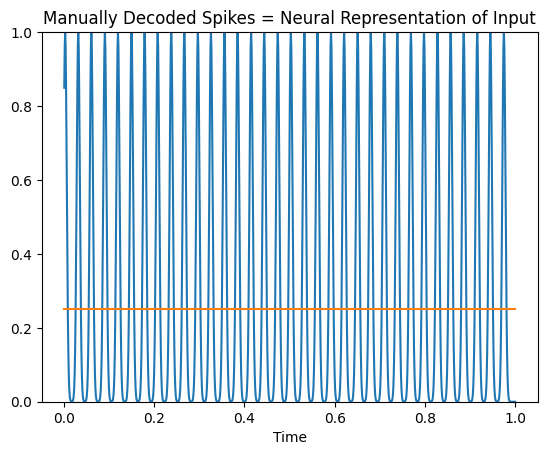

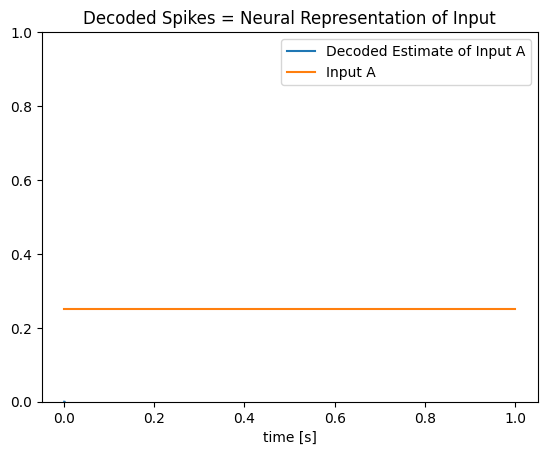

In [32]:
# the tuning curves clear everything, so run again to get our spikes
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(1)

t_sim1 = sim.trange() #time step every .001s
spikes_out = np.squeeze(sim.data[spikes]/1000) #gets rid of 2nd dimension length 1
#time location at which each spike occurs
spike_locs = np.unique(t_sim1*spikes_out)
spike_locs = spike_locs[1:] #get rid of spike at t=0

#funct = gauss_approx*spikes_out
gauss_approx = np.zeros(t_sim1.shape[0])
x = np.arange(0, 1, .001)
for i in spike_locs:
    temp_pdf = norm.pdf(x, i, .0035)
    gauss_approx = np.add(gauss_approx,temp_pdf)

# plot the manually decoded estimate of input A
plt.figure()
plt.plot(t_sim1, gauss_approx/np.max(gauss_approx))
plt.xlabel("Time")
plt.title("Manually Decoded Spikes = Neural Representation of Input")
plt.plot(sim.trange(), sim.data[input_probe_node], label="Input A")
plt.ylim(0,1)

# Plot the input signals and decoded ensemble values
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe_neuron], label="Decoded Estimate of Input A")
plt.plot(sim.trange(), sim.data[input_probe_node], label="Input A")
plt.legend()
plt.ylim(0, 1)
plt.xlabel("time [s]")
plt.title("Decoded Spikes = Neural Representation of Input")


Voila! Now you know everything about encoding and decoding a value.

**Before we move on, try hand tuning the parameters (intercept, encoder, firing rate) and see if you can get a single neuron to better represent our default input value (.5). Then try representing a different value and consider why it doesn't do as well as the first one you tuned (or maybe it does better?).


## Represent (i.e. Encode) Input Data using Eight Neurons

Clearly, one neuron is not the ideal way to go when representing our data - unless we know we have a very specific constant value every single time.

For when that's not the case (examples: time-varying signals or when inputs will be different with each simulation), we need to use ensembles of multiple to many neurons. 

In this example, we will use 8 neurons to represent the function x(t)=2t-1. Nengo documentation recommends to use [Python's lambda functions](https://realpython.com/python-lambda/) when sending a time-varying input to a network.

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


(0.0, 1.0)

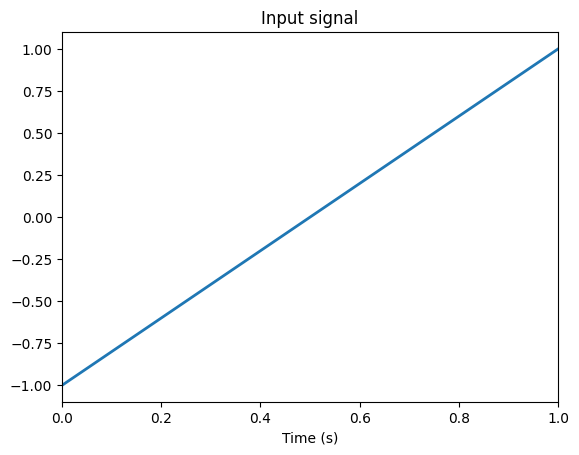

In [34]:
# Clear out data from single neuron representation
sim.clear_probes()

# Create our input using Python Lambda Functions
# Probe that input so we can see the function over time
with model:
    input_node = nengo.Node(lambda t: t * 2 - 1)
    input_probe = nengo.Probe(input_node)

# Run it!
with nengo.Simulator(model) as sim:
    sim.run(1.0)

# Plot input
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe], lw=2)
plt.title("Input signal")
plt.xlabel("Time (s)")
plt.xlim(0, 1)


We will use 8 neurons in a nengo ensemble. Nengo has defaults to randomly assign intercepts, firing rates, and encoder values; however, in this example we will choose specific parameters to (hopefully) make it very clear how multiple neurons combine to represent a single signal.

The tuning curve will assist with understanding the impact of these parameters on how the neurons will represent our input signal.

Build finished in 0:00:01.                                                      


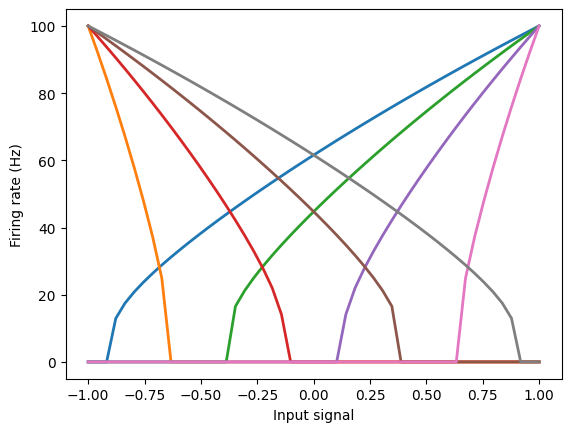

In [39]:
# Makes the tuning curves perfectly spaced out
def aligned(n_neurons, radius=0.9):
    intercepts = np.linspace(-radius, radius, n_neurons) # even spaced from -.9 to .9
    encoders = np.tile([[1], [-1]], (n_neurons // 2, 1)) # half care about negative, half positive
    intercepts *= encoders[:, 0]
    return intercepts, encoders

intercepts, encoders = aligned(8)  # Makes evenly spaced intercepts
with model:
    input_neuron = nengo.Ensemble(
        8,
        dimensions=1,
        intercepts=intercepts,
        max_rates=Uniform(100, 100), #evenly distributed between 80 and 100Hz
        encoders=encoders,
    )

# grab data to plot tuning curves    
with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(input_neuron, sim)

plt.figure()
plt.plot(eval_points, activities, lw=2)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)")
hide_input()

Now, let's connect our input to the neuron ensemble and see the encoded input signal (spiking data out of the neuron ensemble) and compare that against our tuning curves to see if the spikes make sense.

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


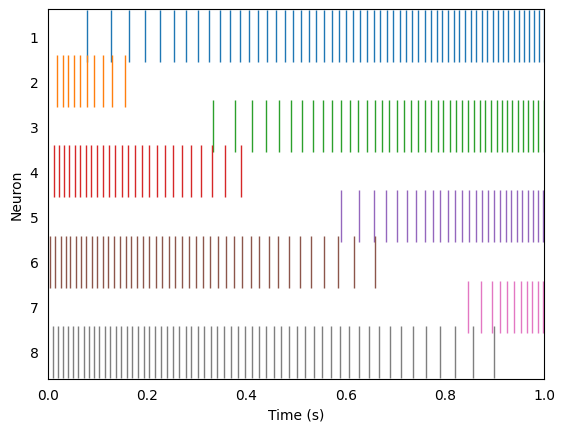

In [40]:
with model:
    inp_conn = nengo.Connection(input_node, input_neuron)
    spikes = nengo.Probe(input_neuron.neurons)
    spikes_filt = nengo.Probe(input_neuron.neurons, synapse=.01)

with nengo.Simulator(model) as sim:
    sim.run(1)

plt.figure()
ax = plt.subplot(1, 1, 1)
rasterplot(sim.trange(), sim.data[spikes], ax)
ax.set_xlim(0, 1)
ax.set_ylabel("Neuron")
ax.set_xlabel("Time (s)")
hide_input()

These track well with our tuning curves. They start firing when the input signal crosses the threshold (intercept) and fires more when it's farther from the intercept in the direction of preference (+1 encoder for more positive, -1 encoder for more negative).

We will now decode our spikes to reconstruct our input signal. Recall how we did this for one neuron: For each binary spike, the biological equivalent is the membrane action potential at that time step. This means you can multiply each spike by the neuron action potential shape. We approximated this shape as a Gaussian curve.

Instead of approximating with a Gaussian curve, we rely on Nengo to multiply each spike by the actual membrane action potential (dependent on tau) and sum those values together for each neuron in the ensemble (just as we did manually for one neuron by estimating the neuron potential as a Gaussian distribution). In Nengo, this is referred to as a post-synaptic filter and we choose tau=.01s.

([<matplotlib.axis.YTick at 0x1df1e257730>,
 [Text(0, 100.0, '0'),
  Text(0, -80.0, '1'),
  Text(0, -260.0, '2'),
  Text(0, -440.0, '3'),
  Text(0, -620.0, '4'),
  Text(0, -800.0, '5'),
  Text(0, -980.0, '6'),
  Text(0, -1160.0, '7')])

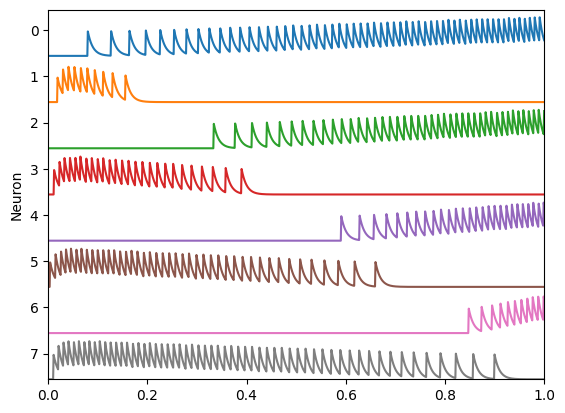

In [41]:
scale = 180
plt.figure()
for i in range(input_neuron.n_neurons):
    plt.plot(sim.trange(), sim.data[spikes_filt][:, i] - i * scale)
plt.xlim(0, 1)
plt.ylim(scale * (-input_neuron.n_neurons + 1), scale)
plt.ylabel("Neuron")
plt.yticks(
    np.arange(scale / 1.8, (-input_neuron.n_neurons + 1) * scale, -scale), np.arange(input_neuron.n_neurons)
)


Then, we multiply the above "filtered spike trains" with decoding weights and sum them together to give an estimate of the input based on the spikes. For a single neuron, we did not have a decoding weight. The decoding weights assign weights to each neuron output based on how important that is to the signal (i.e. more important = higher amplitude when added together). 

Nengo trains decoding weights - similar to weights of a neural network - that are used to reconstruct the input value via spiking neuron outputs. The decoding weights are determined by minimizing the squared difference between the decoded estimate and the actual input signal. Nengo does this for us.

Let's get our decoding values from our model. Because weights are trained values between neuron layers, we need to get the weights from a connection. However, the outputs of our `input_neuron` are not connected to anything. In order to get the weight of each neuron to manually reconstruct (estimate) the input signal, we must create another node (recall: these just pass data) in order to get our 8 decoder weights. 

Build finished in 0:00:01.                                                      
Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


(0.0, 1.0)

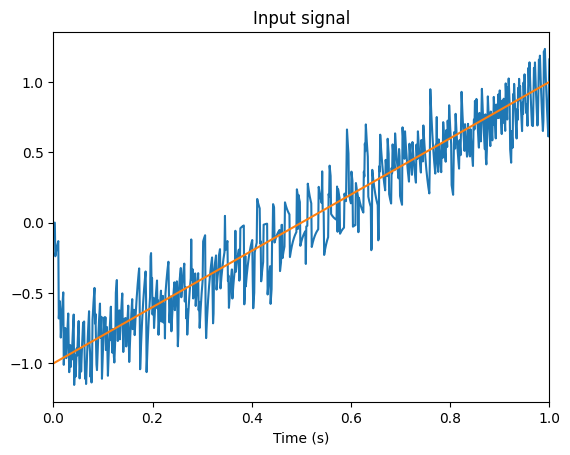

In [43]:
# create and connect an output node
with model:
    output_node = nengo.Node(size_in=1)
    out_conn = nengo.Connection(input_neuron, output_node)
    
# probe the weights from the connection between the neuron and output node (out_conn)
with nengo.Simulator(model) as sim:
    decoders = sim.data[out_conn].weights
# make decoders an array of 8 values
decoders = np.squeeze(decoders)

# run it!
with nengo.Simulator(model) as sim:
    sim.run(1)

# multiply each spike*membrane action potential plots by it's decoder, add them up
n1 = sim.data[spikes_filt][:, 1]
neuron8_rep = np.zeros(n1.shape[0])
for i in range(input_neuron.n_neurons):
    temp_out = decoders[i] * sim.data[spikes_filt][:, i]
    neuron8_rep = np.add(neuron8_rep,temp_out)

plt.figure()
plt.plot(sim.trange(), neuron8_rep, label="Manually Decoded Estimate")
plt.plot(sim.trange(), sim.data[input_probe], label="Input signal")
plt.title("Input signal")
plt.xlabel("Time (s)")
plt.xlim(0, 1)

Let's check how well we did by probing and filtering the output directly (i.e. letting Nengo decode the spikes for us).

Note: Nengo clearly stores the decoder weights somewhere within the neuron ensemble but I haven't found a way to access them. I draw this conclusion because we can simply probe `input_neuron` without it being connected to anything and get the same reconstructed signal that we just manually decoded {insert cranky emoji}.

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


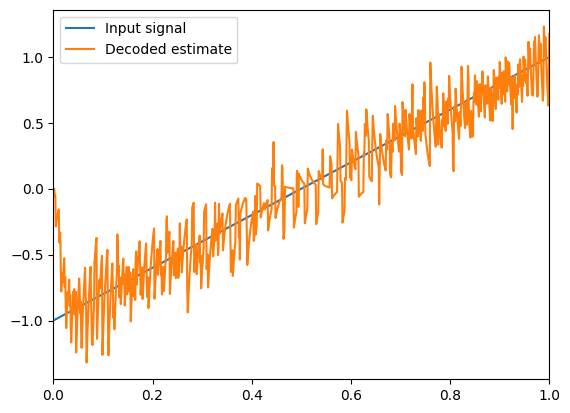

In [44]:
with model:
    neuron_probe = nengo.Probe(input_neuron, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(1)

plt.figure()
plt.plot(sim.trange(), sim.data[input_probe], label="Input signal")
plt.plot(sim.trange(), sim.data[neuron_probe], label="Decoded estimate")
plt.legend(loc="best")
plt.xlim(0, 1)
hide_input()

These look about the same! Go us!

Now you have a solid foundation for representing data using neurons, but there's certainly more to be learned. It would be a VERY SMART idea to take a look at the examples linked in the Discussion section.


### Discussion

More neurons give better representations of an input signal:  
- Check out examples for neuron(s) representing a sinusoid: [one neuron](https://www.nengo.ai/nengo/examples/basic/single-neuron.html), [two neurons](https://www.nengo.ai/nengo/v3.1.0/examples/basic/two-neurons.html), and [many neurons](https://www.nengo.ai/nengo/examples/basic/many-neurons.html)
- The more we can span the space within which we are working, the higher likelihood we have at accurately representing our data. There is a tradeoff though! More neurons means more power, computational complexity, and training time. 
- Hand tuning every neuron is unreasonable, but if we know something useful about our inputs, we can tweak certain parts of the ensemble and as a result reduce the number of neurons required. For instance, if our inputs will never be negative, we can set encoders to only care about positive values and have all other parameters be random. That way we don't have useless neurons that just don't spike. These are things to consider as you choose how to represent your data.

Default Nengo Neuron Parameters:  
- Max firing rates: randomly between 200 and 400Hz  
- Intercepts: randomly vary between -1 and 1  
- Encoders: randomly choose +1 or -1  

Neuron Types:
- There are many neuron types to choose from within Nengo. We learned about classic leaky integrate and fire (LIF) neurons during our neuroscience section. This is the default for Nengo and what we used in this example.
- We will likely stick with LIF neurons, but as we get into our final project, there may be opportunities to explore the other types.
- You can take a look at the [`nengo.neurons` source code](https://www.nengo.ai/nengo/v3.0.0/_modules/nengo/neurons.html) and search `neuronstype` to see your options